This problem comes from OpenAI's [Requests for Research 2.0](https://blog.openai.com/requests-for-research-2/). And the description of this problem is as following:

----

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?
Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?

In [1]:
import numpy
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
tqdm.monitor_interval = 0
import pandas
import pickle

To keep results reproducible, we need to control all the random numbers

In [2]:
random_state=41

# 1. Data generation and split

First we need to generate sequences and their targets

In [3]:
def generate_sequences(sequences_size, lengthes, random_state):
    numpy.random.seed(random_state)
    sequences = []
    labels = []
    for i in tqdm(range(sequences_size)):
        length = numpy.random.choice(lengthes)
        sequences.append(numpy.random.randint(0, 2, size=(length)))
        label = int(sum(sequences[-1]) % 2)
        labels.append(label)
    return sequences, labels

Split the dataset into train+valid and test, then we can split train+valid into train and valid

In [4]:
def train_valid_test_split(sequences, labels, train_valid_test_sizes,
                           random_state):
    assert sum(train_valid_test_sizes) == 1.0
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(
        sequences,
        labels,
        test_size=train_valid_test_sizes[2],
        random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_valid,
        y_train_valid,
        test_size=train_valid_test_sizes[1] /
        (train_valid_test_sizes[0] + train_valid_test_sizes[1]),
        random_state=random_state)
    train = (X_train, y_train)
    valid = (X_valid, y_valid)
    test = (X_test, y_test)
    return train, valid, test

In [5]:
def generate_dataset(sequences_size, lengthes, train_valid_test_sizes,
                     random_state):
    sequences, labels = generate_sequences(sequences_size, lengthes,
                                           random_state)
    return train_valid_test_split(sequences, labels, train_valid_test_sizes,
                                  random_state)

In [6]:
fixed_dataset = generate_dataset(100000, [50], [0.6, 0.2, 0.2], random_state)
var_dataset = generate_dataset(100000, list(range(1, 51)), [0.6, 0.2, 0.2],
                               random_state)

A Jupyter Widget

A Jupyter Widget

# 2. Baseline

Now we can test the performance of our baseline: Logistic Regression.
As the length could be variable, we need to padding those shorter sequences with zeros

In [7]:
def padding(x, length):
    return list(x) + [0] * (length - len(x))


def test_baseline(train, test):
    length = [len(x) for x in train[0]]
    max_length = max(length)
    X_train = [padding(x, max_length) for x in train[0]]
    y_train = train[1]
    X_test = [padding(x, max_length) for x in test[0]]
    y_test = test[1]
    clf = LogisticRegression(C=0.01, penalty='l1')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

Test baseline: LogisticRegression

In [8]:
baseline_accuracy = test_baseline(fixed_dataset[0], fixed_dataset[1])
print('Baseline for fixed length dataset:    %0.4f' % baseline_accuracy)
baseline_accuracy = test_baseline(var_dataset[0], var_dataset[1])
print('Baseline for variable length dataset: %0.4f' % baseline_accuracy)

Baseline for fixed length dataset:    0.4980
Baseline for variable length dataset: 0.5094


# 3. LSTM

First, we need to generate batch data. Here we use class Dataset provided by pytorch

In [9]:
def collate_fn(data):
    sequences = numpy.array([d[0] for d in data])
    labels = numpy.array([d[1] for d in data])
    return sequences, labels


class XOR_Dataset(Dataset):
    def __init__(self, dataset):
        self.sequences = dataset[0]
        self.label = dataset[1]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.label[idx]

Then we can define our LSTM

In [10]:
class LSTM_CLF(nn.Module):
    def __init__(self, emb_dim, hidden_size, layer_number, use_cuda):
        super(LSTM_CLF, self).__init__()
        self.embedding = nn.Embedding(3, emb_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=layer_number,
        )
        self.clf = nn.Sequential(nn.Linear(hidden_size, 2), )
        self.padding_idx = 2
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, sequences, lengths):
        self.embedding.weight.data[self.padding_idx] = 0
        if self.use_cuda:
            sequences = sequences.cuda()
        sequences = Variable(sequences)
        emb = self.embedding(sequences)
        pack = pack_padded_sequence(emb, lengths, batch_first=True)
        output, hidden = lstm.rnn(pack)
        hidden = hidden[0][-1].squeeze()
        return self.clf(hidden)

In [11]:
def test_lstm(lstm, test, use_cuda):
    sequences, labels, lengths = sort_and_padding(test[0], test[1], use_cuda)
    final_layer = lstm(sequences, lengths)
    y_pred = final_layer.topk(1)[1].cpu().data.numpy()
    return accuracy_score(labels, y_pred)

To handle variable length of the input sequences, we need to sort each batch according to their length.
We also need to rearrange the labels accordig to the order of sequences.

In [12]:
def sort_and_padding(sequences, labels, use_cuda):
    '''
    sequences: numpy.array
    labels:numpy.array
    '''
    sequences = numpy.array(sequences)
    labels = numpy.array(labels)
    lengths = [len(x) for x in sequences]
    lengths = Variable(torch.FloatTensor(lengths))
    ordered_len, ordered_idx = lengths.sort(0, descending=True)
    ordered_len = ordered_len.cpu().data.numpy().astype(numpy.int32)
    sequences = sequences[ordered_idx.cpu().data.numpy()]
    labels = labels[ordered_idx.cpu().data.numpy()]
    for i in range(sequences.shape[0]):
        padding_size = int(ordered_len[0] - ordered_len[i])
        sequences[i] = numpy.append(sequences[i], numpy.ones(padding_size) * 2)
        sequences[i] = list(sequences[i].astype(numpy.int32))
    sequences = numpy.array(list(sequences))
    sequences = torch.LongTensor(sequences)
    labels = torch.from_numpy(labels)
    if use_cuda:
        sequences = sequences.cuda()
        labels = labels.cuda()
    return sequences, labels, ordered_len

Now we need to train the lstm model. To make things easier, we need to take all training process as a function so that we can just run this function again when we want to test different parameters.

First, we need to know what we're interested in:

* Accuracy of train, valid and test set
* Losses
* Running time

Second, we also need to know which parameter we may change:

* Different dataset (e.g. length, fixed/variable, batch size)
* Different model (e.g. embedding dimension, hidden size, LSTM/GRU)
* Different optimizer (e.g. optimizing algorithm, learning rate)
* GPU or CPU

In [13]:
def train_lstm(model,
               dataset,
               optimizer,
               batch_size,
               use_cuda,
               MAX_ITER=20,
               use_tqdm=True,
               time_test=False,
               shuffle=True):
    '''
    Train LSTM model
    Arguments:
        model: lstm model
        datasets (tuple): tuple of train,valid and test dataset. Each dataset is a list of binary sequences
        optimizer: initilized optimizer
        batch_size: batch size
        use_cuda: if use GPU to accelerate training
        MAX_ITER: maximum iteration when training.
        use_tqdm: whenther to use tqdm to show the training process bar
        time_test: time_test==True means we don't care the training result but the trainig speed.
                    So we will only run for several epoch to evaluate the execution time 
        shuffle: whether shuffle dataset when using DataLoader
    '''
    criteria = nn.CrossEntropyLoss()
    train, valid, test = dataset
    lstm_train_dataset = DataLoader(
        XOR_Dataset(train),
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle)
    stop_training = False
    train_accuracy = []
    valid_accuracy = []
    test_accuracy = []
    losses = []
    running_time = []
    best_loss = 10000000
    valid_every = 1000
    idx = 0
    if use_tqdm:
        process_bar = tqdm(range(MAX_ITER))
    else:
        process_bar = range(MAX_ITER)
    for epoch in process_bar:
        lstm_train = iter(lstm_train_dataset)
        for sequences, labels in lstm_train:
            start_time = datetime.datetime.now()
            sequences, labels, lengths = sort_and_padding(
                sequences, labels, use_cuda)
            idx += 1
            optimizer.zero_grad()
            labels = Variable(labels)
            final_layer = lstm.forward(sequences, lengths)
            loss = criteria(final_layer, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().data.numpy()[0])
            end_time = datetime.datetime.now()
            running_time.append((end_time - start_time).microseconds)
            if time_test and len(running_time) > 10:
                break
            if idx % valid_every == 0:
                train_accuracy.append(test_lstm(lstm, train, use_cuda))
                valid_accuracy.append(test_lstm(lstm, valid, use_cuda))
                test_accuracy.append(test_lstm(lstm, test, use_cuda))
                if valid_accuracy[-1] == 1.0:
                    stop_training = True
                    break
        if stop_training:
            break

    accuracy = train_accuracy, valid_accuracy, test_accuracy
    return accuracy, losses, running_time

# Fixed v.s. Variable

In [15]:
use_cuda = True
lstm = LSTM_CLF(emb_dim=5, hidden_size=5, layer_number=1, use_cuda=use_cuda)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
accuracy, losses, running_time = train_lstm(
    lstm, var_dataset, optimizer, batch_size=64, use_cuda=use_cuda)

A Jupyter Widget

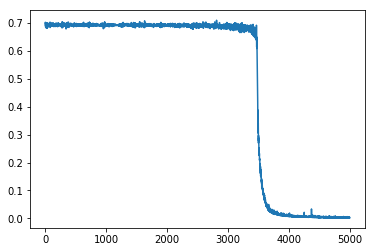

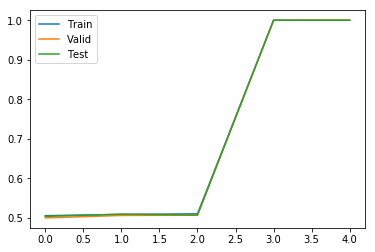

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/adoni/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/adoni/Keck/src/tqdm/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/adoni/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [16]:
plt.plot(losses)
plt.show()
plt.plot(accuracy[0], label='Train')
plt.plot(accuracy[1], label='Valid')
plt.plot(accuracy[2], label='Test')
plt.legend()
plt.show()

In [ ]:
use_cuda = True
lstm = LSTM_CLF(emb_dim=5, hidden_size=5, layer_number=1, use_cuda=use_cuda)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
accuracy, losses, _ = train_lstm(
    lstm, fixed_dataset, optimizer, batch_size=64, use_cuda=use_cuda)

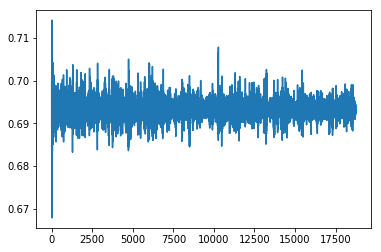

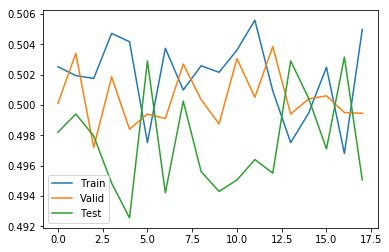

In [49]:
plt.plot(losses)
plt.show()
plt.plot(accuracy[0], label='Train')
plt.plot(accuracy[1], label='Valid')
plt.plot(accuracy[2], label='Test')
plt.legend()
plt.show()

These figures tell us that the performance on variable-length dataset is very good, while the model training on fixed-length dataset is not better than monkey.

My intuiation is that the recursion number on the long sequence is so large and there are so many optimizing direction. However, in variable-length dataset, the model will be trained on both short and long sequence. So the model will get more information about how to ajust the weight.

I gonna use two ways to test our idea.

First, we will see how the accuracy change we we remove some short sequences. That means the smallest sequence length varying from 1 to 10

In [51]:
accuracy_wrt_min_length = []
lenth_range = list(range(1, 10, 2))
for min_length in tqdm(lenth_range):
    dataset = generate_dataset(100000, list(range(min_length, 51)),
                               [0.6, 0.2, 0.2], random_state)
    use_cuda = True
    lstm = LSTM_CLF(
        emb_dim=5, hidden_size=5, layer_number=1, use_cuda=use_cuda)
    optimizer = optim.Adam(lstm.parameters(), lr=0.001)
    accuracy, losses, _ = train_lstm(
        lstm,
        dataset,
        optimizer,
        batch_size=64,
        use_cuda=use_cuda,
        use_tqdm=False)
    accuracy_wrt_min_length.append(max(accuracy[2]))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

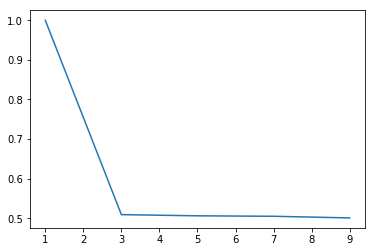

In [53]:
plt.plot(lenth_range, accuracy_wrt_min_length)
plt.show()

Also, we want to know if the converging speed would be different when we sort our dataset with different order (increase v.s. decrease)

In [54]:
var_dataset = generate_dataset(100000, list(range(1, 51)), [0.6, 0.2, 0.2],
                               random_state)

dataset = dict()
dataset['original'] = var_dataset
dataset['increase'] = (sorted(var_dataset[0], key=len), var_dataset[1],
                       var_dataset[2])
dataset['decrease'] = (sorted(var_dataset[0], key=len, reverse=True),
                       var_dataset[1], var_dataset[2])
use_cuda = True

keys = ['original', 'increase', 'decrease']
results = []
for key in keys:
    lstm = LSTM_CLF(
        emb_dim=5, hidden_size=5, layer_number=1, use_cuda=use_cuda)
    optimizer = optim.Adam(lstm.parameters(), lr=0.001)
    accuracy, losses, _ = train_lstm(
        lstm,
        dataset[key],
        optimizer,
        batch_size=64,
        use_cuda=use_cuda,
        use_tqdm=True,
        shuffle=False)
    results.append([accuracy, losses])

A Jupyter Widget

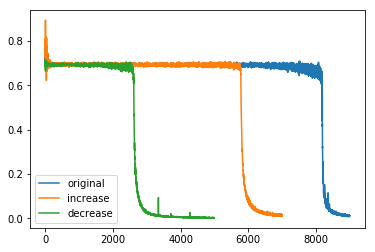

In [55]:
for idx, key in enumerate(keys):
    plt.plot(results[idx][1], label=key)
plt.legend()
plt.show()

# Running time

We want to see the execution speed of w.r.t. different device, embedding dimension, layer number and batch size.

To make things easier, we gonna make hidden size equal to embedding size.

In [17]:
running_time = pandas.DataFrame(
    [], columns=['Time', 'Device', 'Embedding Dimension', 'Layer Number'])
embedding_dimensions = list(range(50, 650, 100))
layer_numbers = [1, 2, 3, 4, 5, 6]
for use_cuda in [False, True]:
    for emb_dim in tqdm(embedding_dimensions):
        for layer_number in layer_numbers:
            lstm = LSTM_CLF(
                emb_dim=emb_dim,
                hidden_size=emb_dim,
                layer_number=layer_number,
                use_cuda=use_cuda)
            optimizer = optim.Adam(lstm.parameters(), lr=0.001)
            _, _, rt = train_lstm(
                lstm,
                var_dataset,
                optimizer,
                batch_size=64,
                use_cuda=use_cuda,
                MAX_ITER=1,
                use_tqdm=False,
                time_test=True)
            device = 'GPU' if use_cuda else 'CPU'
            data = []
            for t in rt:
                data.append([t, device, emb_dim, layer_number])
            new_df = pandas.DataFrame(data, columns=running_time.columns)
            running_time = pandas.concat([running_time, new_df])

A Jupyter Widget

A Jupyter Widget

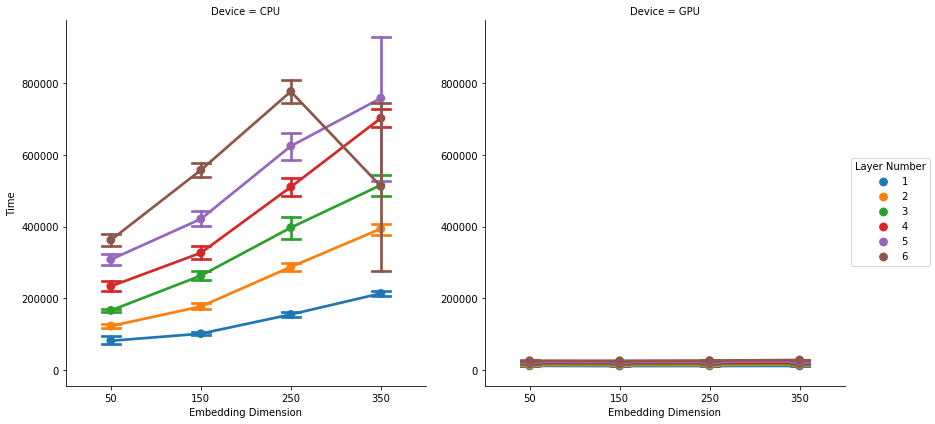

In [27]:
sns.factorplot(
    x="Embedding Dimension",
    y="Time",
    hue="Layer Number",
    col="Device",
    data=running_time[running_time['Embedding Dimension'] < 450],
    capsize=.2,
    size=6,
    aspect=1)
plt.show()

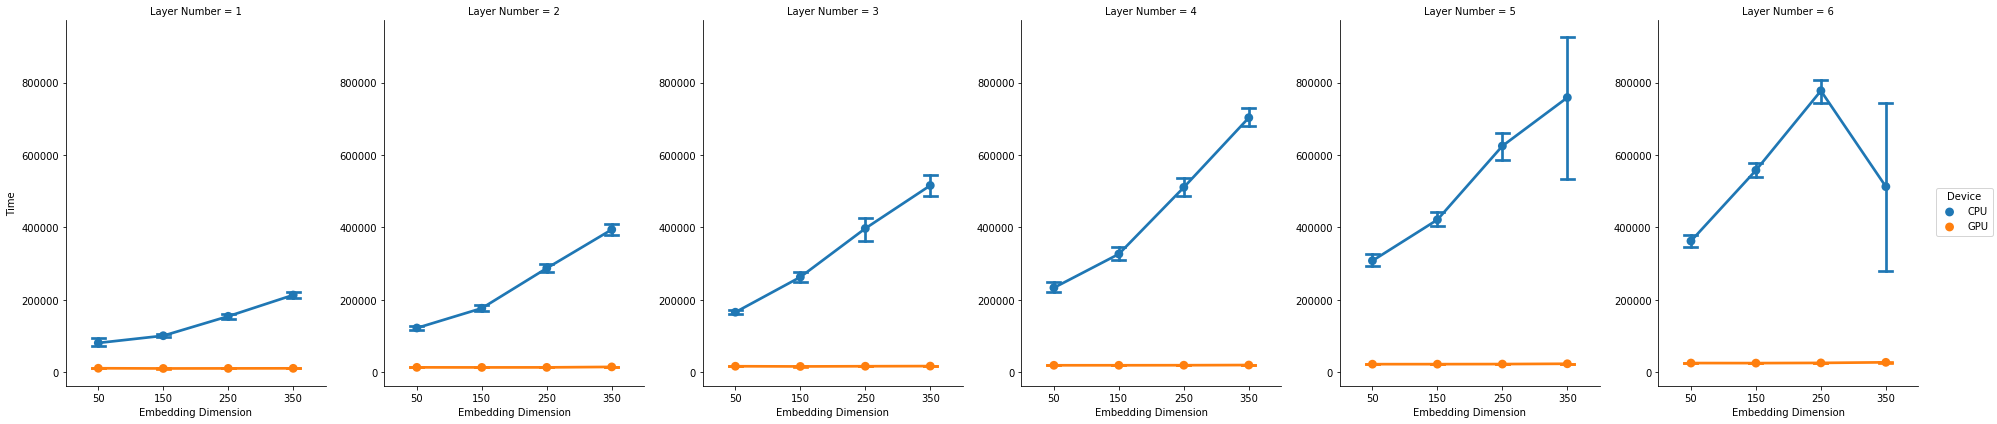

In [24]:
sns.factorplot(
    x="Embedding Dimension",
    y="Time",
    hue="Device",
    col="Layer Number",
    data=running_time[running_time['Embedding Dimension'] < 450],
    capsize=.2,
    size=6,
    aspect=.75)
plt.show()

Good thing is from this two pictures we can conclude that the GPU is faster than CPU.
The advantage of GPU will be even larger withe the increase of embedding dimension

Bad thing is the curve is weird when layer_number>4, in which case the running time going down when embedding size larger than 450.

Another conclusion is that with CPU execution time will increase with embedding dimension and layer number,
while GPU execution time didn't show sensitive to that. That may because the bottleneck is not the GPU operation.

To test this idea, we would like to test the bottleneck of train_lstm

In [29]:
%load_ext line_profiler

In [30]:
%lprun -f train_lstm train_lstm(lstm, fixed_dataset, optimizer, batch_size=64, use_cuda=True)

A Jupyter Widget


*** KeyboardInterrupt exception caught in code being profiled.

![](bottleneck.png)

The bottleneck is indeed the forward and backward process. So the intuition may be wrong.

# Effect of differnt model

A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/adoni/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/adoni/Keck/src/tqdm/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/adoni/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



A Jupyter Widget

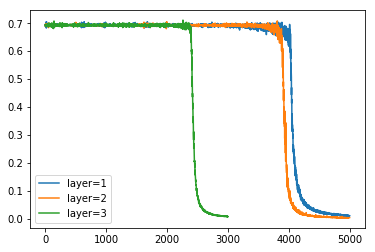

In [31]:
torch.cuda.manual_seed(random_state)
torch.manual_seed(random_state)
optimizing_losses = []
for layer_size in range(1, 4):
    use_cuda = True
    lstm = LSTM_CLF(
        emb_dim=5, hidden_size=5, layer_number=layer_size, use_cuda=use_cuda)
    optimizer = optim.Adam(lstm.parameters(), lr=0.001)
    accuracy, losses, _ = train_lstm(
        lstm, var_dataset, optimizer, batch_size=64, use_cuda=use_cuda)
    plt.plot(losses, label='layer=%d' % layer_size)
plt.legend()
plt.show()

It seems with more layers we can learn faster.

# Effect of batch size

A Jupyter Widget

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/adoni/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/adoni/Keck/src/tqdm/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/adoni/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/adoni/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/adoni/Keck/src/tqdm/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/adoni/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/adoni/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/adoni/Keck/src/tqdm/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/adoni/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



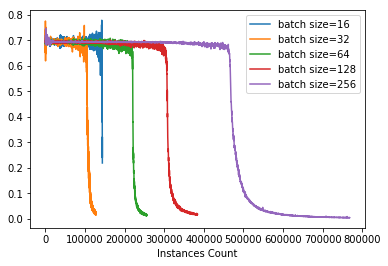

In [32]:
torch.cuda.manual_seed(random_state)
torch.manual_seed(random_state)
optimizing_losses = []
for b_size in [16, 32, 64, 128, 256]:
    use_cuda = True
    lstm = LSTM_CLF(
        emb_dim=5, hidden_size=5, layer_number=1, use_cuda=use_cuda)
    optimizer = optim.Adam(lstm.parameters(), lr=0.001)
    accuracy, losses, _ = train_lstm(
        lstm, var_dataset, optimizer, batch_size=b_size, use_cuda=use_cuda)
    instance_count = numpy.array(range(1, len(losses) + 1)) * b_size
    plt.plot(instance_count, losses, label='batch size=%d' % b_size)
plt.xlabel('Instances Count')
plt.legend()
plt.show()

Here we plot the loss w.r.t. instances count to see the effect of batch size on converge speed.

We can see that larger batch size will converge slower.
As this problem is so easy, the advantage of larger batch size is not obvious

# TODO

* Different Optimize Algorithm: Now we only use Adam, but there are other options.
* Explore more about why the performance is so bad on fixed-length dataset. Bugs or the limit of lstm.
* Why GPU running time doesn't increase obviously with 
* Why execution time decrease for CPU when layer number>4 and embedding dimesion>450
* Try embedding_dimension=2 and plot the hidden layer in plane and try to see how it change with input

# Take home for myself

* No matter what we do, finish it with document. In this way, we will treat it seriously and learn more about that, especially some details.
* If we believe a problem is just something we want to play with, then finish it quickly. This project started three weeks ago and I always want to make it better. However, the main code is finished within one day. I could have finish it within three days.
* When we don't know what to do, try to see what other people are doing. That's the first time that I know [Requests for Research](https://blog.openai.com/requests-for-research-2/). Maybe I can find more from twitter or researcher's homepage.
* How to define a problem clearly, like input and output, evaluation method, dataset, baseline and some discussion. Do that before starting a project will make us more clear about what we want to do.